In [36]:
import pandas as pd
import numpy as np
import datetime
import re
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk
from collections import Counter

## Utils

In [2]:
def cleanhtml(raw_html):
    """
    this function gets an html text and removes all the garbage marks
    """
    clean_code_r = re.compile('<code>.*?</code>')
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',re.sub(clean_code_r, '', raw_html))
    cleantext = cleantext.replace('\n',' ')
    return cleantext

def extract_code(raw_html):
    code_text = " ".join(re.findall(re.compile('<code>(.*?)</code>'),raw_html))
    return code_text

def clean_dataframe(df,int_columns,datetime_columns,text_columns):
    """
    This function gets a dataframe as an input and does the following transformations:
    1. type conversion - integers and datetime.
    2. clean html tags from text
    Important note: Unknown dates are converted to 1/1/1900
    """
    for col in int_columns:
        df[col]=df[col].fillna(0).astype(int)
    for col in datetime_columns:
        df[col]=[datetime.datetime.strptime(str(x),"%Y-%m-%dT%H:%M:%S.%f") if len(str(x))>4 else datetime.datetime(1900,1,1) for x in df[col]]
    for col in text_columns:
        df["%s_Code"%col]=[extract_code(text) for text in df[col]]
        df[col]=[cleanhtml(text) for text in df[col]]
    return df
def get_post_label(post_id,parent_id,accepted_answer_ids):
    if post_id in accepted_answer_ids:
        return 'Accepted answer'
    elif parent_id > 0:
        return 'Answer'
    else:
        return 'Question'

## Read and clean posts data

In [3]:
tree = ET.parse('data/Posts.xml')
root = tree.getroot()
posts_df = pd.DataFrame([x.attrib for x in root.getchildren()])
posts_df.columns

Index(['AcceptedAnswerId', 'AnswerCount', 'Body', 'ClosedDate', 'CommentCount',
       'CommunityOwnedDate', 'CreationDate', 'FavoriteCount', 'Id',
       'LastActivityDate', 'LastEditDate', 'LastEditorDisplayName',
       'LastEditorUserId', 'OwnerDisplayName', 'OwnerUserId', 'ParentId',
       'PostTypeId', 'Score', 'Tags', 'Title', 'ViewCount'],
      dtype='object')

In [4]:
int_columns = int_columns=['AcceptedAnswerId','AnswerCount','CommentCount','FavoriteCount','Id','LastEditorUserId',
             'OwnerUserId','ParentId','PostTypeId','Score','ViewCount']
datetime_columns = ['ClosedDate','CommunityOwnedDate','CreationDate','LastActivityDate','LastEditDate']
text_columns=['Body']


posts_df = clean_dataframe(posts_df,int_columns,datetime_columns,text_columns)
posts_df.head()

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount,Body_Code
0,0,1,I've always been interested in machine learnin...,2014-05-14 14:40:25.950,1,1900-01-01,2014-05-13 23:58:30.457,1,5,2014-05-14 00:36:31.077,...,0,NaN,5,0,1,8,<machine-learning>,How can I do simple machine learning without h...,412,
1,10,3,"As a researcher and instructor, I'm looking fo...",2014-05-14 08:40:54.950,4,1900-01-01,2014-05-14 00:11:06.457,1,7,2014-05-16 13:45:00.237,...,97,NaN,36,0,1,4,<education><open-source>,What open-source books (or other materials) pr...,363,
2,0,0,"Not sure if this fits the scope of this SE, bu...",1900-01-01 00:00:00.000,0,1900-01-01,2014-05-14 00:36:31.077,0,9,2014-05-14 00:36:31.077,...,0,NaN,51,5,2,5,NaN,NaN,0,
3,0,0,"One book that's freely available is ""The Eleme...",1900-01-01 00:00:00.000,1,1900-01-01,2014-05-14 00:53:43.273,0,10,2014-05-14 00:53:43.273,...,0,NaN,22,7,2,12,NaN,NaN,0,
4,29,4,I am sure data science as will be discussed in...,1900-01-01 00:00:00.000,1,1900-01-01,2014-05-14 01:25:59.677,4,14,2014-06-20 17:36:05.023,...,322,NaN,66,0,1,19,<data-mining><definitions>,Is Data Science the Same as Data Mining?,999,


## Assign labels
* If we want to add categories like 'high ranked'\'low ranked' we can just edit the get_label function

In [5]:
accepted_answer_ids = list(set(posts_df['AcceptedAnswerId']))
posts_df['post_label'] = [get_post_label(post_id,parent_id,accepted_answer_ids) for post_id,parent_id in zip(posts_df['Id'],posts_df['ParentId'])]
posts_df['post_label'].value_counts()

Question           8884
Answer             7323
Accepted answer    3006
Name: post_label, dtype: int64

## Read and clean comments data
*Not sure if we need the comments. Read this data anyway

In [6]:
tree = ET.parse('data/Comments.xml')
root = tree.getroot()
comments_df=pd.DataFrame([x.attrib for x in root.getchildren()])
comments_df.columns

int_columns = ['Id','PostId','Score','UserId']
datetime_columns = ['CreationDate']
text_columns = ['Text']

comments_df = clean_dataframe(comments_df,int_columns,datetime_columns,text_columns)

In [7]:
def show_distribution(df):
    n, bins, patches = plt.hist(df)
    plt.show()

## Questions score distribution

In [8]:
questions_scores = posts_df[posts_df["post_label"]=="Question"]["Score"]

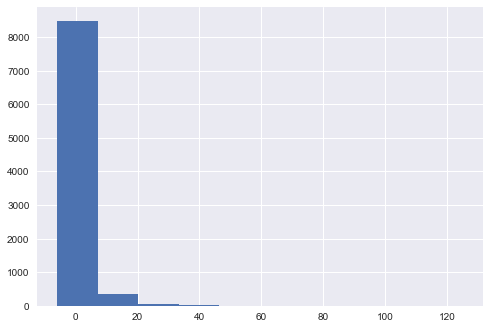

In [9]:
show_distribution(questions_scores)

In [16]:
high_ranked_question_threshold = np.percentile(questions_scores, 90)
high_ranked_question_threshold

5.0

In [17]:
low_ranked_question_threshold = np.percentile(questions_scores, 10)
low_ranked_question_threshold

0.0

## Answers score distribution

In [18]:
answers_scores = posts_df[(posts_df["post_label"]=="Answer")|(posts_df["post_label"]=="Accepted answer")]["Score"]

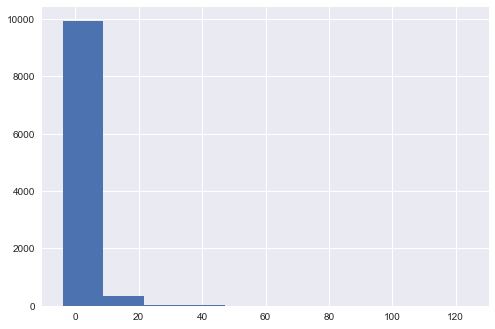

In [19]:
show_distribution(answers_scores)

In [20]:
high_ranked_answers_threshold = np.percentile(answers_scores, 90)
high_ranked_answers_threshold

5.0

In [21]:
low_ranked_answers_threshold = np.percentile(answers_scores, 10)
low_ranked_answers_threshold

0.0

## Label the posts rank

In [22]:
def get_post_rank(post_label,post_score):
    if post_label=="Question":
        if post_score>=high_ranked_question_threshold:
            return "High"
        elif post_score<=low_ranked_question_threshold:
            return "Low"
        else:
            return "Normal"
    else:
        if post_score>=high_ranked_answers_threshold:
            return "High"
        elif post_score<=low_ranked_answers_threshold:
            return "Low"
        else:
            return "Normal"

In [23]:
posts_df["post_rank"] = [get_post_rank(post_label,post_score) for post_label,post_score in zip(posts_df["post_label"],posts_df["Score"])]
posts_df['post_rank'].value_counts()

Normal    11510
Low        5435
High       2268
Name: post_rank, dtype: int64

## Stractural feature extraction

In [29]:
pos_tags = ["CC","CD","DT","EX","FW","IN","JJ","JJR","JJS","LS","MD","NN","NNS","NNP","NNPS","PDT","POS","PRP","PRP$","RB","RBR","RBS","RP","SYM","TO","UH","VB","VBD","VBG","VBN","VBP","VBZ","WDT","WP","WP$","WRB"]

In [30]:
question_feature_names = ["text_length","number_of_links","code_percentage"]
for tag in pos_tags:
    question_feature_names.append("%s_count"%tag)

In [59]:
def extract_stractural_features(df):
    df["text_length"] = df["Body"].map(lambda x: len(x)) + df["Body_Code"].map(lambda x: len(x))
    df["number_of_links"] = df["Body"].map(lambda x: x.count("http://"))
    df["code_percentage"] = df["Body_Code"].map(lambda x: len(x)) / df["text_length"]
    pos_counts = posts_df["Body"].map(lambda body: Counter([x[1] for x in pos_tag(word_tokenize(body))]))
    for tag in pos_tags:
        df["%s_count"%tag] = pos_counts.map(lambda x:x[tag])     

In [60]:
extract_stractural_features(posts_df)

In [61]:
posts_df

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,VB_count,VBD_count,VBG_count,VBN_count,VBP_count,VBZ_count,WDT_count,WP_count,WP$_count,WRB_count
0,0,1,I've always been interested in machine learnin...,2014-05-14 14:40:25.950,1,1900-01-01 00:00:00.000,2014-05-13 23:58:30.457,1,5,2014-05-14 00:36:31.077,...,9,1,2,2,4,1,0,0,0,3
1,10,3,"As a researcher and instructor, I'm looking fo...",2014-05-14 08:40:54.950,4,1900-01-01 00:00:00.000,2014-05-14 00:11:06.457,1,7,2014-05-16 13:45:00.237,...,1,0,1,0,3,1,2,0,0,0
2,0,0,"Not sure if this fits the scope of this SE, bu...",1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 00:36:31.077,0,9,2014-05-14 00:36:31.077,...,12,2,6,1,6,7,4,2,0,2
3,0,0,"One book that's freely available is ""The Eleme...",1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 00:53:43.273,0,10,2014-05-14 00:53:43.273,...,0,0,1,1,1,6,1,0,0,0
4,29,4,I am sure data science as will be discussed in...,1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 01:25:59.677,4,14,2014-06-20 17:36:05.023,...,3,1,0,2,3,3,0,2,0,1
5,0,0,In which situations would one system be prefer...,2014-05-14 07:41:49.437,1,1900-01-01 00:00:00.000,2014-05-14 01:41:23.110,0,15,2014-05-14 01:41:23.110,...,1,0,0,1,1,0,1,1,0,0
6,46,2,I use Libsvm to train data and predict classif...,1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 01:57:56.880,0,16,2014-05-17 16:24:14.523,...,4,2,0,0,2,2,1,0,0,0
7,0,0,LIBSVM is a library for support vector classif...,1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 02:49:14.580,0,17,2014-05-16 13:44:53.470,...,0,1,0,1,0,1,0,0,0,0
8,0,0,,1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 02:49:14.580,0,18,2014-05-14 02:49:14.580,...,0,0,0,0,0,0,0,0,0,0
9,37,12,Lots of people use the term big data in a rath...,1900-01-01 00:00:00.000,5,1900-01-01 00:00:00.000,2014-05-14 03:56:20.963,16,19,2016-11-25 22:34:51.253,...,4,1,1,3,4,4,0,1,0,1
